In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.sparse

In [2]:
from tectosaur.mesh.combined_mesh import CombinedMesh
from tectosaur.constraint_builders import continuity_constraints, \
    all_bc_constraints, free_edge_constraints
from tectosaur.ops.sparse_integral_op import SparseIntegralOp, FMMFarfieldBuilder
from tectosaur.ops.mass_op import MassOp
from tectosaur.ops.sum_op import SumOp
from tectosaur.constraints import build_constraint_matrix, ConstraintEQ, Term
import tectosaur_topo as tt

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22

In [4]:
import logging
logging.getLogger('tectosaur').setLevel(logging.WARNING)
logging.getLogger('tectosaur_topo').setLevel(logging.WARNING)

In [5]:
def get_vert_vals(m, x):
    vert_tris = [[] for i in range(m[0].shape[0])]
    for i in range(m[1].shape[0]):
        for d in range(3):
            vert_tris[m[1][i,d]].append(i)
    vert_n_tris = [len(ts) for ts in vert_tris]
    vert_vals = np.zeros(m[0].shape[0])
    for i in range(m[1].shape[0]):
        for d in range(3):
            vert_vals[m[1][i,d]] += x[i]
    vert_vals /= vert_n_tris
    return vert_vals

def make_inversion_plot(x, name, slip_min, slip_max):
    vert_vals = get_vert_vals(fault, x)

    triang = tri.Triangulation(fault[0][:,0] / 1000.0, fault[0][:,2] / 1000.0, fault[1])
    refiner = tri.UniformTriRefiner(triang)
    tri_refi, z_test_refi = refiner.refine_field(vert_vals, subdiv=3)

    plt.figure(figsize = (15, 3.5))
    ax = plt.gca()
    ax.set_aspect('equal')
    # plt.triplot(triang, lw = 0.5, color = 'white')

    levels = np.linspace(slip_min, slip_max, 19)
    # cmap = cm.get_cmap(name='terrain', lut=None)
    cmap = cm.get_cmap(name='winter')
    cntf = plt.tricontourf(tri_refi, z_test_refi, levels=levels, cmap=cmap)
    plt.tricontour(
        tri_refi, z_test_refi, levels=levels,
        linestyles = 'solid',
        colors=['k'],
        linewidths=[0.5]
    )


    plt.xticks(np.linspace(-35.0, 35.0, 15))
    plt.yticks(np.linspace(-3.0, -15.0, 5))
    plt.xlabel('$x \\mathrm{(km)}$')
    plt.ylabel('$z \\mathrm{(km)}$')

    plt.title('')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1.5%", pad=0.5)
    cbar = plt.colorbar(cntf, cax = cax)
    cbar.set_label('$s \\mathrm{(m)}$')
    cbar.set_ticks(levels[::2])
    #cbar.set_ticklabels(levels[::2])
    plt.savefig(name + '.pdf', bbox_inches = 'tight')
    plt.show()

def strike_component(x):
    return x[1::2]

def dip_component(x):
    return x[0::2]

In [6]:
flat_surf_pts, slip_vecs, flat_gfs, hill_surf_pts, hill_gfs, hill_surf, flat_surf, fault = np.load('gfs100/test_gfs.npy')

In [7]:
obs_pt_idxs = np.random.randint(flat_surf_pts.shape[0], size = (1000,))
obs_pt_idxs = np.arange(0, flat_surf_pts.shape[0])
which_dims = [0,1]
noise_magnitude = 0.0
slip = np.array([3.5, 0.0, 0.0])
reg_param = 0.0375

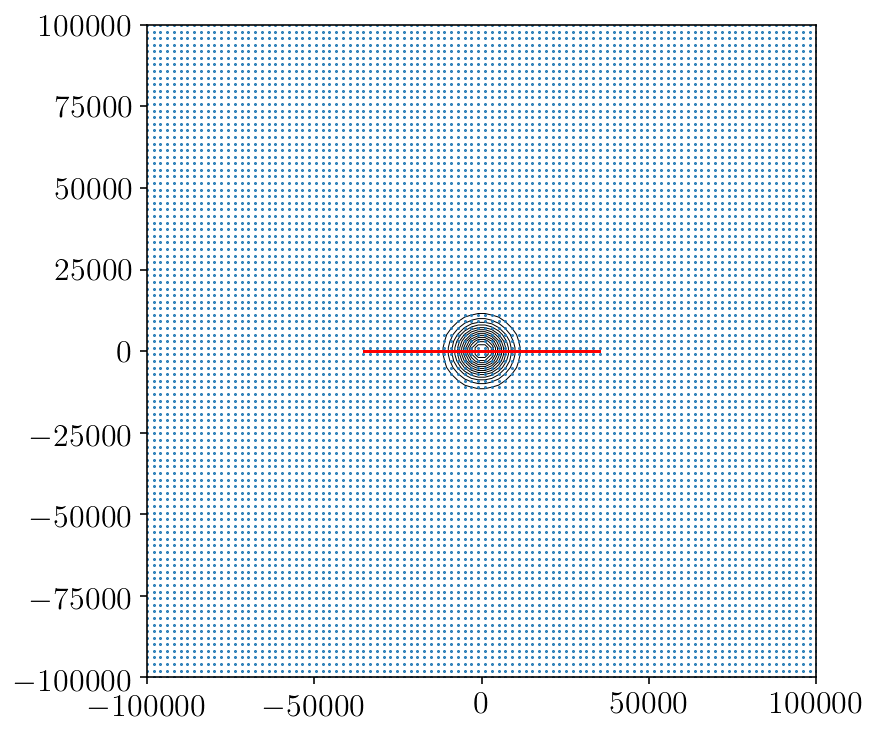

In [16]:
from scipy.interpolate import griddata
w = np.max(hill_surf_pts[:,0])
xi = np.linspace(-w,w,100)
yi = np.linspace(-w,w,100)

z = hill_surf_pts[:, 2]
zi = griddata((hill_surf_pts[:,0], hill_surf_pts[:,1]), z, (xi[None,:], yi[:,None]), method='cubic')

min_z, max_z = np.min(z), np.max(z)
levels = np.linspace(min_z, max_z, 15)[1:]
plt.figure(figsize = (6,6))
CS = plt.contour(xi,yi,zi,levels = levels, linewidths=0.5, colors='k')

min_faultx = np.min(fault[0][:,0])
max_faultx = np.max(fault[0][:,0])

plt.plot([min_faultx, max_faultx], [0,0], 'r-', markersize = 0.5)
plt.plot(flat_surf_pts[obs_pt_idxs,0], flat_surf_pts[obs_pt_idxs,1], 'o', markersize = 0.5)
plt.show()

# Plot the location of observation point (blue dots) the fault (red line), topo (background contours).
# Not intended to be pretty, just for orienting myself!

In [9]:
rhs_G = hill_gfs
inv_rhs = np.zeros(obs_pt_idxs.shape[0] * len(which_dims))
for i in range(rhs_G.shape[0]):
    s = slip_vecs[i,0,:]
    # project the desired slip vector onto the gf slip vectors.
    proj = s.dot(slip) / np.linalg.norm(s)
    # sum to resulting rhs
    inv_rhs += proj * rhs_G[i,obs_pt_idxs,:][:,which_dims].flatten()
inv_rhs += np.random.normal(0, noise_magnitude, inv_rhs.shape[0])

xs = []
# for reg_param in (2.0 ** (-np.arange(16))):
for G in [flat_gfs, hill_gfs]:
    A = G[:,obs_pt_idxs][:,:,which_dims].reshape((G.shape[0], -1)).T
    A += reg_param * np.eye(*A.shape)
    x = np.linalg.lstsq(A, inv_rhs)[0]
    xs.append(x)

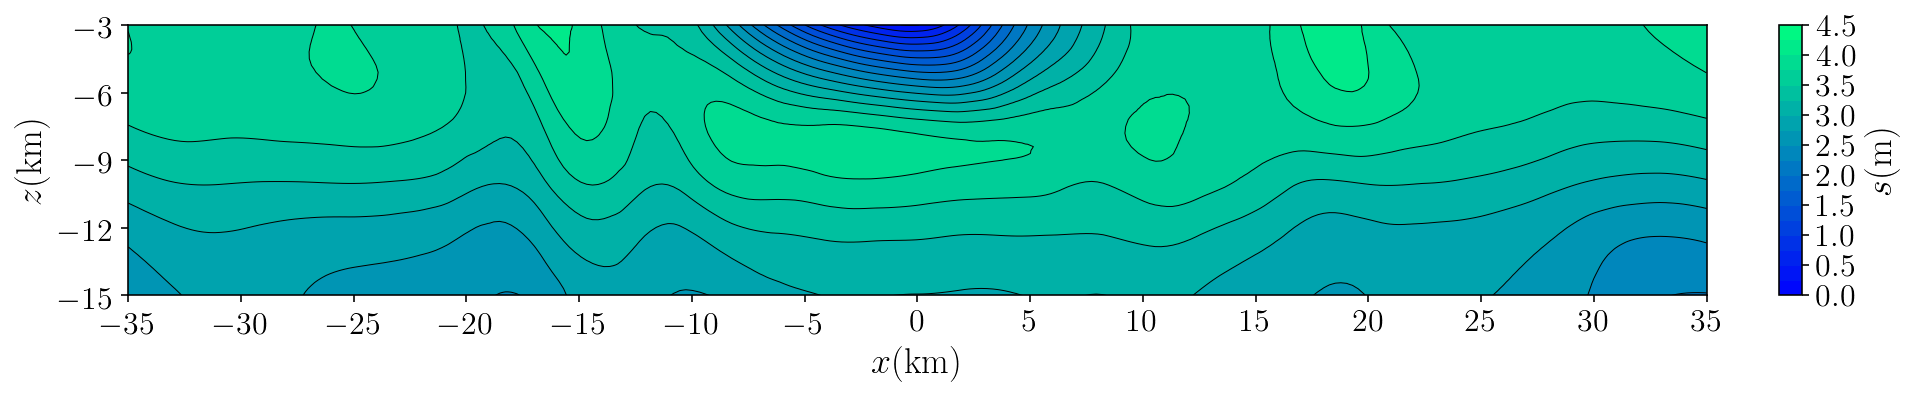

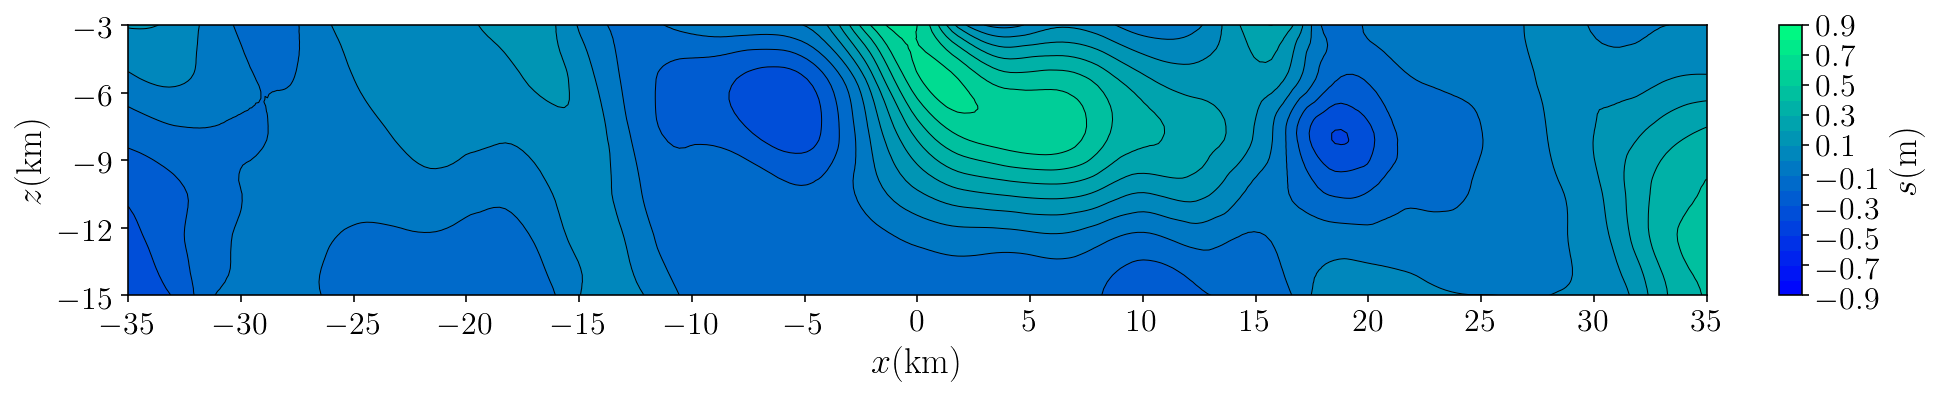

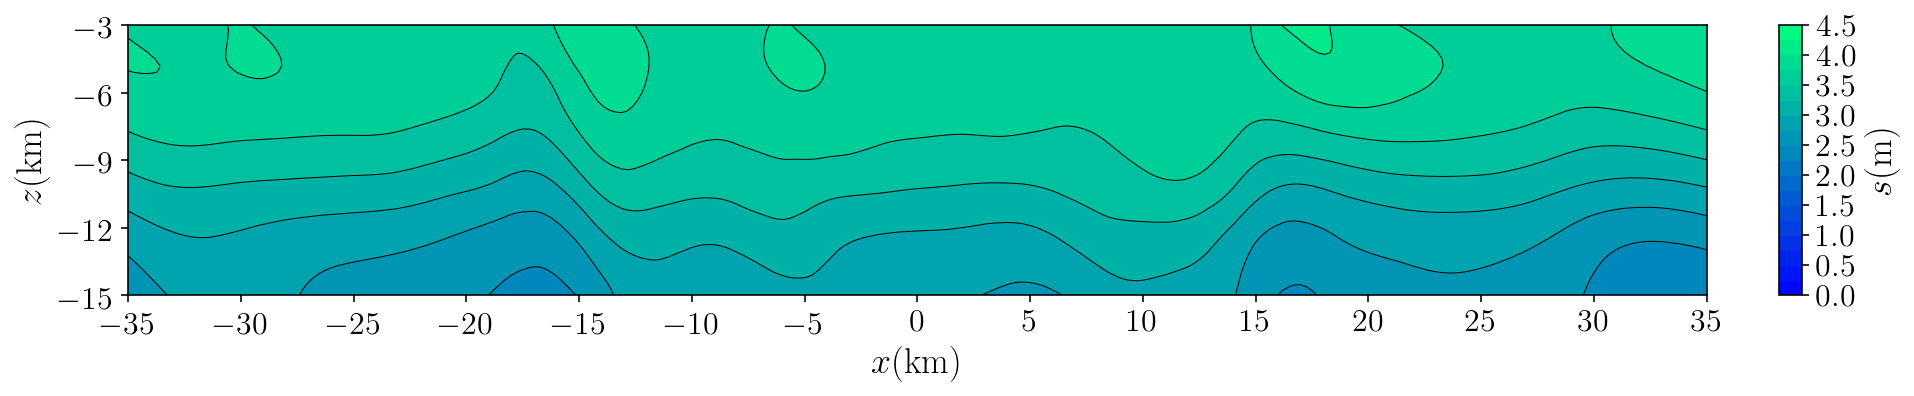

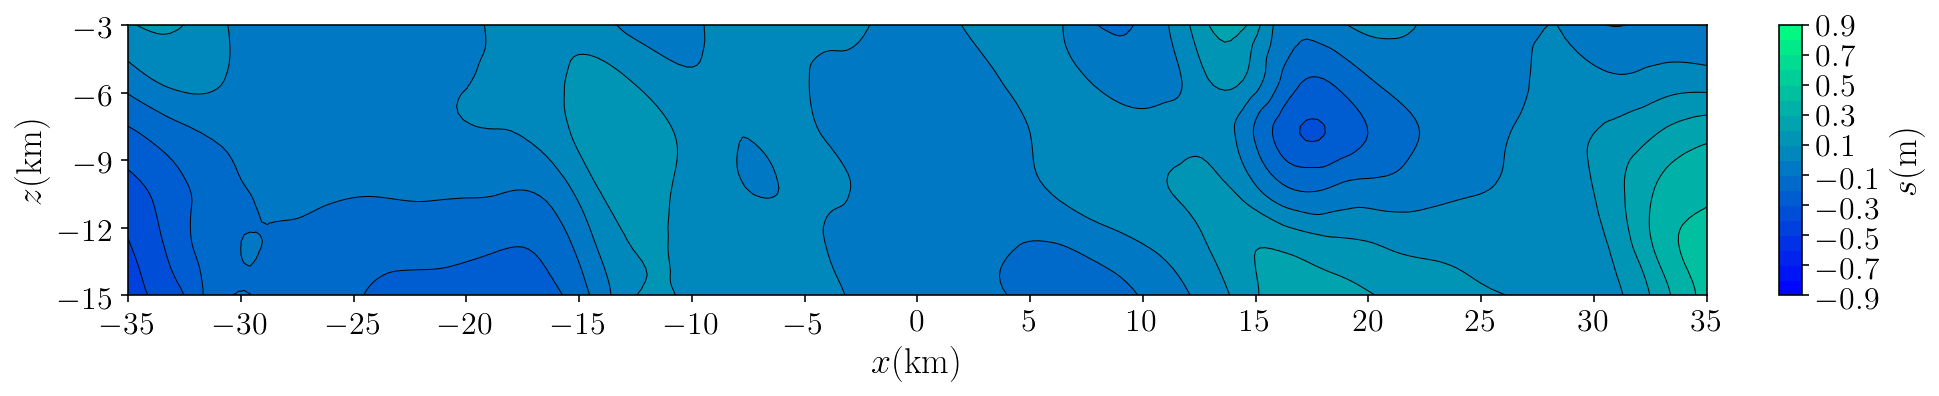

In [10]:
%matplotlib inline
assert(fault[1].shape[0] == xs[0].shape[0] / 2)
make_inversion_plot(-strike_component(xs[0]), 'flat_ss', 0, 4.5)
make_inversion_plot(-dip_component(xs[0]), 'flat_ds', -0.9, 0.9)
make_inversion_plot(-strike_component(xs[1]), 'hill_ss', 0, 4.5)
make_inversion_plot(-dip_component(xs[1]), 'hill_ds', -0.9, 0.9)

### Here, I'm trying the iterative Green's function inversion method.

In [11]:
m = CombinedMesh([('surf', flat_surf), ('fault', fault)])
tris = m.get_piece_tris('surf')
surf_pts_map = np.unique(tris)
surf_pts = m.pts[surf_pts_map]
soln_to_surf_disp = scipy.sparse.dok_matrix((
    surf_pts.shape[0] * len(which_dims), 
    m.tris.shape[0] * 9
))
done_pts = dict()
for i in range(tris.shape[0]):
    for b in range(3):
        if tris[i,b] in done_pts:
            continue
        if tris[i,b] not in obs_pt_idxs:
            continue
        done_pts[tris[i,b]] = 1
        for d in which_dims:
            out_idx = tris[i,b] * len(which_dims) + d
            soln_to_surf_disp[out_idx, i * 9 + b * 3 + d] = 1.0
assert(soln_to_surf_disp.shape[0] == soln_to_surf_disp.getnnz())

In [12]:
fault_slip = np.array([[1, 0, 0]] * 3 * fault[1].shape[0]).flatten()
s_pts, s_tris, fault_start_idx, soln_hill = tt.forward(hill_surf, fault, fault_slip, 1.0, 0.25)
u_hill = soln_to_surf_disp.dot(soln_hill)
s_pts, s_tris, fault_start_idx, soln_flat = tt.forward(flat_surf, fault, fault_slip, 1.0, 0.25)
u_flat = soln_to_surf_disp.dot(soln_flat)

[31735:INFO:tectosaur_topo.forward]
    tectosaur_topo.solve_topo configuration: 
{'float_type': <class 'numpy.float32'>,
 'fmm_mac': 3.0,
 'fmm_order': 150,
 'preconditioner': 'none',
 'pts_per_cell': 450,
 'quad_far_order': 2,
 'quad_mass_order': 3,
 'quad_near_order': 5,
 'quad_near_threshold': 2.0,
 'quad_vertadj_order': 6,
 'solver_tol': 1e-08,
 'verbose': True}
[35002:DEBUG:tectosaur.util.gpu]
    start compiling nearfield/nearfield.cl
[35764:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0
[37061:DEBUG:tectosaur.util.gpu]
    compile took 2.0596277713775635
[37080:DEBUG:tectosaur.nearfield.nearfield_op]
        setup pairs integrator took 2.1396710872650146
[37800:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- load table took 0.003288745880126953
[37881:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- get pts took 0.07933950424194336
[37889:DEBUG:tectosaur.util.gpu]
    start compiling nearfield/interpolate_kernel.cl
[38192:DEBUG:tectosaur.util.gpu]
 

[44496:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.10255265235900879
[44499:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0014684200286865234
[44502:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.11318635940551758
[44505:DEBUG:tectosaur_topo.solve]
    iteration # 1 took 0.11734199523925781
[44507:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[44511:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.0012173652648925781
[44517:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[44625:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.10858345031738281
[44627:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.1147003173828125
[44629:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0014529228210449219
[44632:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.12528729438781738
[44636:DEBUG:tectosaur_topo.solve]
    iteration # 2 took 0.1298

[45864:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.1062614917755127
[45867:DEBUG:tectosaur_topo.solve]
    iteration # 12 took 0.10985565185546875
[45868:DEBUG:tectosaur_topo.solve]
    residual: 9.912271413105159e-06
[45870:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[45873:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.00112152099609375
[45879:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[45970:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.09110331535339355
[45972:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.09753799438476562
[45974:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0015516281127929688
[45977:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.10697484016418457
[45980:DEBUG:tectosaur_topo.solve]
    iteration # 13 took 0.11060404777526855
[45981:DEBUG:tectosaur_topo.solve]
    residual: 4.378729715899531e-06
[45983:DEBUG:tectosaur.

[51455:DEBUG:tectosaur.util.gpu]
    returning cached gpu module nearfield/nearfield.cl
[51800:DEBUG:tectosaur.nearfield.table_lookup]
    adjacent -- vert adj subpairs took 0.34465622901916504
[52711:DEBUG:tectosaur.nearfield.table_lookup]
    adjacent -- vert adj subbasis took 0.9101336002349854
[52716:DEBUG:tectosaur.nearfield.nearfield_op]
        Edge adjacent took 1.6248998641967773
[52729:DEBUG:tectosaur.nearfield.nearfield_op]
        Edge adjacent correction took 0.01177668571472168
[52887:DEBUG:tectosaur.nearfield.nearfield_op]
        Vert adjacent took 0.1574723720550537
[52945:DEBUG:tectosaur.nearfield.nearfield_op]
        Vert adjacent correction took 0.05609393119812012
[53229:DEBUG:tectosaur.nearfield.nearfield_op]
        Nearfield took 0.28267407417297363
[53475:DEBUG:tectosaur.nearfield.nearfield_op]
        Nearfield correction took 0.2449193000793457
[53668:DEBUG:tectosaur.nearfield.nearfield_op]
        Assemble matrix took 0.19133687019348145
[53669:DEBUG:tectos

[55795:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.0969243049621582
[55797:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0013518333435058594
[55800:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.10619974136352539
[55803:DEBUG:tectosaur_topo.solve]
    iteration # 4 took 0.10971450805664062
[55804:DEBUG:tectosaur_topo.solve]
    residual: 0.13197079965518518
[55805:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[55809:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.001138448715209961
[55814:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[55917:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.10300350189208984
[55918:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.10875916481018066
[55921:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0014767646789550781
[55924:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.11851572990417

[57090:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0013489723205566406
[57092:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.10640573501586914
[57095:DEBUG:tectosaur_topo.solve]
    iteration # 15 took 0.10993838310241699
[57096:DEBUG:tectosaur_topo.solve]
    residual: 7.136510275897001e-07
[57099:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[57102:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.0011341571807861328
[57107:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[57198:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.09125638008117676
[57200:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.09700179100036621
[57202:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0013473033905029297
[57205:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.10632848739624023
[57208:DEBUG:tectosaur_topo.solve]
    iteration # 16 took 0.109828948974609

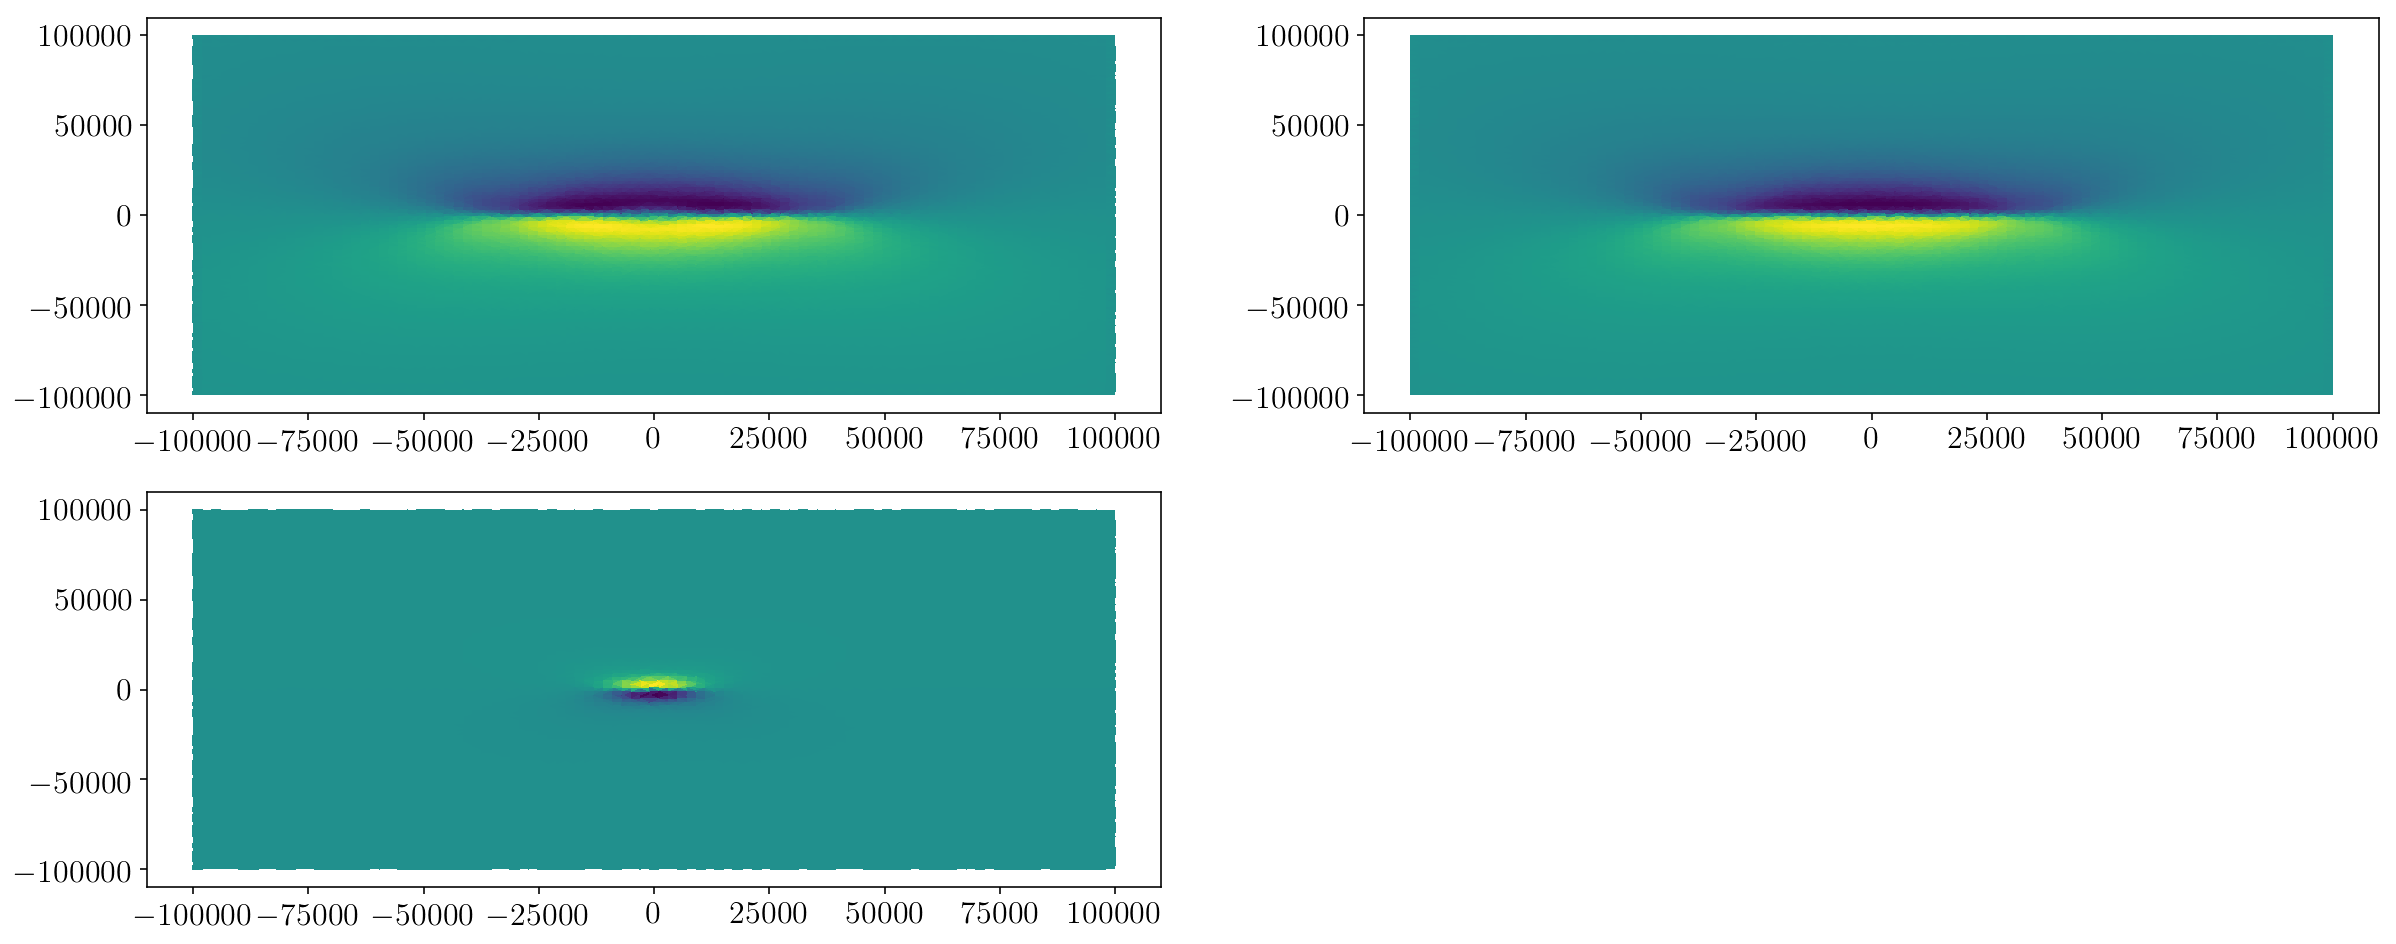

In [13]:
t = tri.Triangulation(surf_pts[:,0], surf_pts[:,1])

plt.figure(figsize = (20, 8))
plt.subplot('221')
plt.tripcolor(t, u_hill.reshape((-1,2))[:,0])
plt.subplot('222')
plt.tripcolor(t, u_flat.reshape((-1,2))[:,0])
plt.subplot('223')
plt.tripcolor(t, (u_hill - u_flat).reshape((-1,2))[:,0])
plt.show()

In [14]:
forward_system = tt.forward_assemble(flat_surf, fault, 1.0, 0.25)
adjoint_system = tt.adjoint_assemble(flat_surf, fault, 1.0, 0.25)
def mv(v):
    _,_,_,soln = tt.forward(forward_system, v)
    return soln_to_surf_disp.dot(soln)

def rmv(v):
    rhs = soln_to_surf_disp.T.dot(v)
    _,_,_,soln = tt.adjoint(flat_surf, fault, )

n_slip = fault[1].shape[0] * 9
n_data = u_hill.shape[0]
A = scipy.sparse.linalg.LinearOperator((n_data, n_slip), matvec = mv, rmatvec = mv)
inverse_soln = scipy.sparse.linalg.lsmr(A, u_hill)

AttributeError: module 'tectosaur_topo' has no attribute 'solve_topo'

### Below, I'm trying a direct inversion method based on lagrange multipliers